# Data Simulation with `msprime`

This notebook introduces the `msprime` simulator, a high‑performance library for generating ancestry and mutation data under the coalescent. It supports separate ancestry and mutation simulation via the succinct tree sequence data structure. `msprime` is widely used in population genetics because it can simulate whole chromosomes efficiently and stores results compactly using `tskit`.

## Simulating a constant population

We simulate a chromosome of length 5 Mb with a constant effective population size of 10,000 individuals. We set the mutation and recombination rates to 1e-8 per base per generation.

In [1]:
import msprime
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# Parameters
sequence_length = 5_000_000
ne = 10000
mutation_rate = 1e-8
recombination_rate = 1e-8
samples = 10  # number of diploid individuals

# Demography: constant population
demography = msprime.Demography()
demography.add_population(initial_size=ne)

# Simulate ancestry and mutations
ts_anc = msprime.sim_ancestry(samples=samples,
                            recombination_rate=recombination_rate,
                            sequence_length=sequence_length,
                            demography=demography)
ts = msprime.sim_mutations(ts_anc, rate=mutation_rate)

print('Tree sequence has', ts.num_sites, 'segregating sites and', ts.num_trees, 'trees.')

Tree sequence has 6880 segregating sites and 5784 trees.


The simulation generates a tree sequence `ts`, which is essentially a record of how all sampled individuals coalesce back to their common ancestors. By placing mutations along the branches of these ancestral trees (according to the specified mutation rate), `msprime` outputs simulated genetic variation—ultimately yielding SNP data or variant matrices that can be used for downstream analyses, such as training neural posterior estimators in our pipeline. 

Let us check the SNP matrix from the tree sequence.

In [36]:
genotypes = ts.genotype_matrix()  # Shape: (n_variants, n_samples)
print('Genotype matrix shape:', genotypes.shape)

Genotype matrix shape: (6880, 20)


In [47]:
# genotypes

This is the type of data we can use as the input for our population size inference later. 

Now there are multiple ways how to make this high-dimensional data accessible for the neural posterior estimation network. We need to provide features to the NPE network. These features can be predefined **summary statistics** based on snps and their positions or can be extracted by a neural embedding network. 

An embedding network can either be pretrained or trained jointly with the NPE network in an end-to-end manner. However, in this workshop, we will stick with using predefined summary statistics.

## Summary statistics: site frequency spectrum (SFS)
SFS counts how many mutations appear in exactly k haploids.

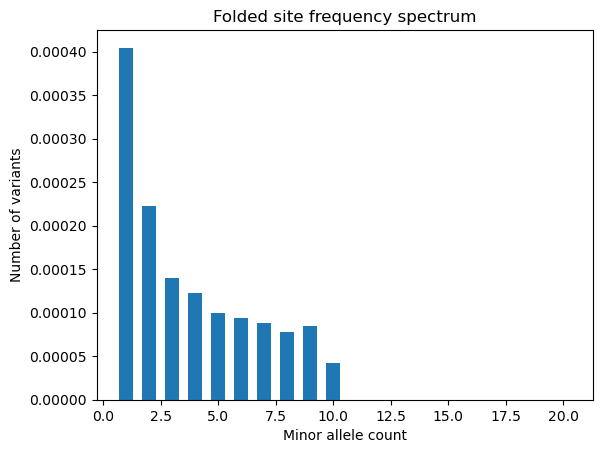

In [45]:
# Compute and plot the folded SFS
sfs = ts.allele_frequency_spectrum()
freqs = np.arange(1, len(sfs))
plt.bar(freqs, sfs[1:], width=0.6)
plt.xlabel('Minor allele count')
plt.ylabel('Number of variants')
plt.title('Folded site frequency spectrum')
plt.show()

With SFS, we now have a pair of theta and x (the population size, and sfs from its SNP matrix) for NPE.